#  **Setup and checks**





In [1]:
import tensorflow as tf
if tf.__version__!="2.0.0-beta1":
  !pip install --upgrade tensorflow-gpu==2.0.0b1
  print("updated Tensorflow library")
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random
import tensorflow_datasets as tfds


assert tf.__version__=="2.0.0-beta1", "Upgrade tf, then restart runtime"
assert tf.test.is_gpu_available(), "Connect GPU"

keras = tf.keras

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia")
!pwd &ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia
 chest_xray
 chest_xray_dataset
'Copy of ResNet.ipynb'
 Data_exploration.ipynb
 hello_test.txt
 inception_log.txt
 inception_v3_model_2.h5
 inception_v3_model.h5
 main_inception_incremental.ipynb
 main_inception.ipynb
 main.ipynb
 main_ResNet.ipynb
 Models_ensemble.ipynb
 Paper
 Prepare_Kaggle.ipynb
 ResNet.ipynb
 ResNet_log.txt
 ResNet_model.h5
 resnet_train_cache.tf-data_0.data-00000-of-0000



# Load data:
All images will be resized to IMG_SIZE x IMG_SIZE,  and input channels rescaled to a range of [-1,1].


In [2]:
IMG_SIZE = 256 # All images will be resized to this size
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32
num_train, num_val, num_test = 5216, 16, 624
count = 16
SPLIT_PRECETNTAGE = 0.9

DATA_ROOT = "/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia"
DATA_ROOT = pathlib.Path(DATA_ROOT)


ALL_LOC = pathlib.Path(str(DATA_ROOT) + '/chest_xray/train')
all_imgs_paths = list(ALL_LOC.glob('*/*.jpeg'))
all_imgs_paths = [str(path) for path in all_imgs_paths]
random.shuffle(all_imgs_paths)

label_names = sorted(item.name for item in ALL_LOC.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))

all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_imgs_paths]
""
image_count = len(all_imgs_paths)
split_edge = round(image_count * SPLIT_PRECETNTAGE)

train_paths, train_labels = all_imgs_paths[:split_edge], all_image_labels[:split_edge]
val_paths, val_labels =all_imgs_paths[split_edge:], all_image_labels[split_edge:] 

print(len(train_paths), len(val_paths), len(all_imgs_paths))

for i in range(5):
  print(train_labels[i], train_paths[i])

####################################################################################################
TEST_LOC = pathlib.Path(str(DATA_ROOT) + '/chest_xray/test')
test_imgs_paths = list(TEST_LOC.glob('*/*.jpeg'))
test_imgs_paths = [str(path) for path in test_imgs_paths]
random.shuffle(test_imgs_paths)

test_label_names = sorted(item.name for item in TEST_LOC.glob('*/') if item.is_dir())
test_label_to_index = dict((name, index) for index, name in enumerate(test_label_names))

test_image_labels = [test_label_to_index[pathlib.Path(path).parent.name]
                    for path in test_imgs_paths]
""
test_image_count = len(test_imgs_paths)

test_paths, test_labels = test_imgs_paths, test_image_labels

print("\nTrain images are %d image, but Test images are %d." % (len(train_paths), len(test_paths)))


for i in range(5):
  print(test_labels[i], test_paths[i])


4694 522 5216
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person620_bacteria_2492.jpeg
0 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0827-0001.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person1924_bacteria_4832.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person1358_bacteria_3463.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person266_bacteria_1248.jpeg

Train images are 4694 image, but Test images are 624.
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/test/PNEUMONIA/person53_virus_108.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/test/PNEUMONIA/person118_bacteria_559.jpeg
0 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_p

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = image/127.5 -1 # normalize to [-1,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def show_patient(img, label):
  img = img.numpy()
  print(img.shape)
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
  fig.suptitle(label_names[label].title(), fontsize=24)
#   plt.subplots_adjust(hspace=0.1, top=0.1, bottom=0.05)
  for i, ax in enumerate(axs.flat):
      ax.imshow(img[...,i], "gray")
  plt.show()
    
test_path = '/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray_dataset/NORMAL/NORMAL2-IM-1109-0001.jpeg'
label = 0

# plt.imshow(load_and_preprocess_image(test_path))
# plt.grid(False)
# plt.xlabel("TEST")
# plt.title(label_names[label].title())
# print()

# img = load_and_preprocess_image(test_path)
# show_patient(img, label)



In [0]:
""" Building a dataset """


ds_train = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = ds_train.map(load_and_preprocess_from_path_label)

train_ds = train_ds.shuffle(buffer_size=500)
train_ds = train_ds.repeat()
training_batches = train_ds.batch(BATCH_SIZE)

ds_val = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = ds_val.map(load_and_preprocess_from_path_label)

validation_batches = val_ds.cache() # filename='./resnet_val_cache.tf-data'
validation_batches = validation_batches.batch(BATCH_SIZE)#.prefetch(1)

ds_test = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = ds_test.map(load_and_preprocess_from_path_label)

test_batches = test_ds.batch(BATCH_SIZE)#.prefetch(1)

In [0]:
'''
i, k = 0, 0
for img_batch, labels in validation_batches.take(16):
  print(i)
  labels = labels.numpy()
  print(labels)
  for img, label in zip(img_batch, labels):
#     show_patient(img, label)
    print('\t',k)
    k+=1
  i+=1
  k=0
'''

"\ni, k = 0, 0\nfor img_batch, labels in validation_batches.take(16):\n  print(i)\n  labels = labels.numpy()\n  print(labels)\n  for img, label in zip(img_batch, labels):\n#     show_patient(img, label)\n    print('\t',k)\n    k+=1\n  i+=1\n  k=0\n"

In [0]:
baseModel = tf.keras.applications.inception_v3.InceptionV3(include_top=False, 
                                                           weights='imagenet', 
                                                           input_tensor=None, 
                                                           input_shape=IMG_SHAPE, 
                                                           pooling=None) 
baseModel.trainable = False

print(len(baseModel.layers))

87916544/87910968 [==============================] - 7s 0us/step
311


In [0]:
baseModel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

dense_layer = keras.layers.Dense(128)

prediction_layer = keras.layers.Dense(2, activation='sigmoid')



# > **Now building and compiling our model:**

1.   Stacking baseModel with the classifier head.
2.   Compiling the model.




In [5]:
train_new_model = False
if(train_new_model == True):
  model = tf.keras.Sequential([
                              baseModel,
                              global_average_layer,
                              dense_layer,
                              prediction_layer
                              ])
else:
  model = tf.keras.models.load_model('./inception_v3_model_2.h5')


W0729 13:09:20.171163 139788852467584 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.85, beta_2=0.95, epsilon=1e-08),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 22,065,314
Trainable params: 262,530
Non-trainable params: 21,802,784
_________________________________________________________________




# Train the last two layers of the model:
baseModel is frozen, only the added classifier head is being trained.



In [0]:
# num_train, num_val, num_test = 5216, 16, 624

validation_steps = 5

no_epochs = 10
steps_per_epoch=tf.math.ceil(len(all_imgs_paths)/BATCH_SIZE).numpy()

loss0,accuracy0 = model.evaluate(test_batches, steps = 5) #validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


5/5 [==============================] - 38s 8s/step - loss: 0.8427 - accuracy: 0.4906
initial loss: 0.84
initial accuracy: 0.49


In [0]:
print(model.fit.__doc__)

In [0]:
history = model.fit(training_batches,
                    epochs=50, #no_epochs,
                    validation_data=validation_batches,
                    validation_steps= 5, #validation_steps,
                    steps_per_epoch=5)

Epoch 1/50


W0729 10:23:39.171793 139626295248768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


5/5 [==============================] - 313s 63s/step - loss: 0.6567 - accuracy: 0.6500 - val_loss: 0.6078 - val_accuracy: 0.7188
Epoch 2/50
5/5 [==============================] - 62s 12s/step - loss: 0.6111 - accuracy: 0.7125 - val_loss: 0.5903 - val_accuracy: 0.7156
Epoch 3/50
5/5 [==============================] - 64s 13s/step - loss: 0.5245 - accuracy: 0.7531 - val_loss: 0.6084 - val_accuracy: 0.7188
Epoch 4/50
5/5 [==============================] - 62s 12s/step - loss: 0.4857 - accuracy: 0.7844 - val_loss: 0.6082 - val_accuracy: 0.7188
Epoch 5/50
5/5 [==============================] - 62s 12s/step - loss: 0.5557 - accuracy: 0.6906 - val_loss: 0.5648 - val_accuracy: 0.7375
Epoch 6/50
5/5 [==============================] - 66s 13s/step - loss: 0.4713 - accuracy: 0.7875 - val_loss: 0.5637 - val_accuracy: 0.7406
Epoch 7/50
5/5 [==============================] - 64s 13s/step - loss: 0.4504 - accuracy: 0.8125 - val_loss: 0.6580 - val_accuracy: 0.7125
Epoch 8/50
5/5 [=====================

In [0]:
model.evaluate(test_batches, steps = validation_steps)

5/5 [==============================] - 2s 433ms/step - loss: 0.9068 - accuracy: 0.6531


[0.9068464279174805, 0.653125]



# Fine tune the model:



In [0]:
baseModel.trainable = True

fine_tune_at = 30

# Freeze all the layers before the `fine_tune_at` layer
for layer in baseModel.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.SGD(lr=0.00001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 22,065,314
Trainable params: 21,692,514
Non-trainable params: 372,800
_________________________________________________________________


In [0]:
no_epochs = 50
fine_tune_epochs = 100
total_epochs =  no_epochs + fine_tune_epochs

history_fine = model.fit(training_batches,
                         epochs=total_epochs,
                         initial_epoch = no_epochs,
                         steps_per_epoch = 5,
                         validation_data = validation_batches)


Epoch 51/150
5/5 [==============================] - 254s 51s/step - loss: 0.2892 - accuracy: 0.8594 - val_loss: 0.5233 - val_accuracy: 0.7692
Epoch 52/150
5/5 [==============================] - 15s 3s/step - loss: 0.2505 - accuracy: 0.9031 - val_loss: 0.4956 - val_accuracy: 0.7797
Epoch 53/150
5/5 [==============================] - 15s 3s/step - loss: 0.2250 - accuracy: 0.9062 - val_loss: 0.4676 - val_accuracy: 0.7941
Epoch 54/150
5/5 [==============================] - 15s 3s/step - loss: 0.2297 - accuracy: 0.9031 - val_loss: 0.4412 - val_accuracy: 0.8027
Epoch 55/150
5/5 [==============================] - 15s 3s/step - loss: 0.3302 - accuracy: 0.8469 - val_loss: 0.4236 - val_accuracy: 0.8094
Epoch 56/150
5/5 [==============================] - 15s 3s/step - loss: 0.2082 - accuracy: 0.9187 - val_loss: 0.4050 - val_accuracy: 0.8218
Epoch 57/150
5/5 [==============================] - 15s 3s/step - loss: 0.2527 - accuracy: 0.8875 - val_loss: 0.3886 - val_accuracy: 0.8266
Epoch 58/150
5/5 [

Text(0.5, 0, 'epoch')

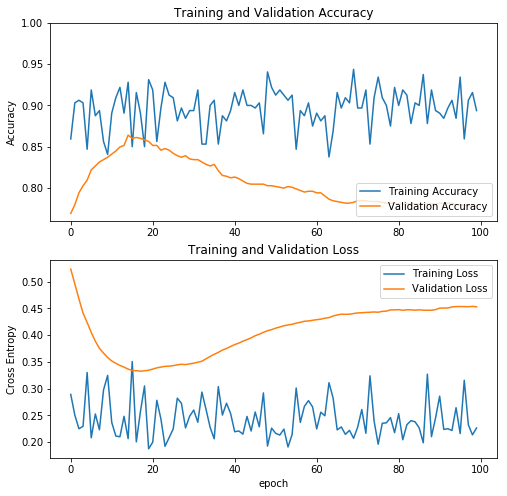

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

In [0]:
model.evaluate(test_batches, steps = validation_steps)

5/5 [==============================] - 2s 454ms/step - loss: 0.7985 - accuracy: 0.6500


[0.7985439777374268, 0.65]

In [0]:
model.save('./inception_v3_model_2.h5')

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 22,065,314
Trainable params: 21,692,514
Non-trainable params: 372,800
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [7]:
f = open("inception_log.txt", "a")

acc_fine = []
val_acc_fine = []
loss_fine = []
val_loss_fine = []

for i in range(4):
  fine_tune_epochs = 50 #* (i+1)
  no_epochs = 400 + 50 * (i)
  total_epochs =  no_epochs + fine_tune_epochs
  history_fine = model.fit(training_batches,
                         epochs=total_epochs,
                         initial_epoch = no_epochs,
                         steps_per_epoch = 5,
                         validation_data = validation_batches,
                         verbose=2)
  model.save('./inception_v3_model_2.h5')
  
  print("\n\nFinished loop nmber %d\nwith Total epochs of %d\n\n"% (i, total_epochs))
  f.write("%d: Finished a loop\n" % (i))
  f.write("Finished loop nmber %d\nwith Total epochs of %d\n"% (i, total_epochs))

  acc_fine.append(history_fine.history['accuracy'])
  val_acc_fine.append(history_fine.history['val_accuracy'])

  loss_fine.extend(history_fine.history['loss'])
  val_loss_fine.extend(history_fine.history['val_loss'])
  

f.close()


Epoch 401/450
5/5 - 495s - loss: 0.2083 - accuracy: 0.9344 - val_loss: 0.4876 - val_accuracy: 0.7701
Epoch 402/450
5/5 - 79s - loss: 0.1403 - accuracy: 0.9500 - val_loss: 0.5034 - val_accuracy: 0.7797
Epoch 403/450
5/5 - 55s - loss: 0.2047 - accuracy: 0.8875 - val_loss: 0.3816 - val_accuracy: 0.8276
Epoch 404/450
5/5 - 55s - loss: 0.1370 - accuracy: 0.9531 - val_loss: 0.4057 - val_accuracy: 0.8142
Epoch 405/450
5/5 - 58s - loss: 0.2579 - accuracy: 0.9250 - val_loss: 0.6504 - val_accuracy: 0.7615
Epoch 406/450
5/5 - 55s - loss: 0.1200 - accuracy: 0.9656 - val_loss: 0.8586 - val_accuracy: 0.7529
Epoch 407/450
5/5 - 53s - loss: 0.0680 - accuracy: 0.9750 - val_loss: 0.7422 - val_accuracy: 0.7615
Epoch 408/450
5/5 - 56s - loss: 0.0715 - accuracy: 0.9688 - val_loss: 0.6670 - val_accuracy: 0.7720
Epoch 409/450
5/5 - 57s - loss: 0.1060 - accuracy: 0.9500 - val_loss: 0.7490 - val_accuracy: 0.7644
Epoch 410/450
5/5 - 56s - loss: 0.0472 - accuracy: 0.9812 - val_loss: 0.8734 - val_accuracy: 0.7567

In [8]:
model.evaluate(test_batches, steps = 5)

5/5 [==============================] - 40s 8s/step - loss: 1.9890 - accuracy: 0.7406


[1.9890491724014283, 0.740625]

Text(0.5, 0, 'epoch')

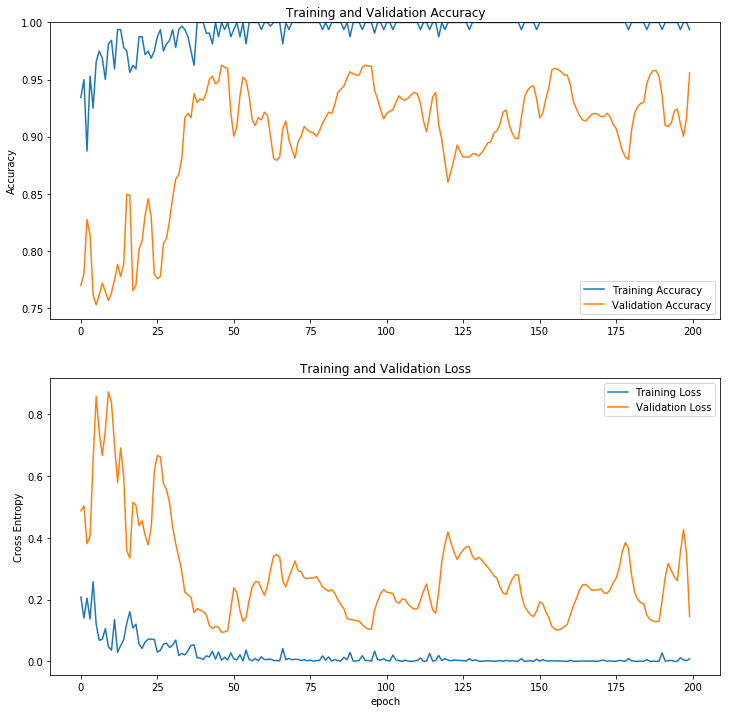

In [9]:
flatten = lambda l: [item for sublist in l for item in sublist]
# x = flatten(list(acc_fine))
# xx = flatten(val_acc_fine)
# y = flatten(loss_fine)
# yy = flatten(val_loss_fine)

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(flatten(acc_fine), label='Training Accuracy')
plt.plot(flatten(val_acc_fine), label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_fine, label='Training Loss')
plt.plot(val_loss_fine, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')